# Wrangling and Analyzing Data

## 1. Introduction

- This project shows my data wrangling skills using data from Twitter (WeRateDogs) clean it, and do some analysis. Apart Twiiter data I'll use an image prediction dataset, to build my analysis. 

- One fact about WeRateDogs is that it has a unique rating system. People rate dogs but with a denominator of 10 and the numerator greater than 10 to show how cute the dog is.

## 2. Gathering Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import requests
import tweepy
import re

%matplotlib inline

### 2.1 Import the on hand twitter data

In [2]:
twitter_df = pd.read_csv('twitter-archive-enhanced.csv')

### 2.2 Getting the image prediction dataset from my Google drive

In [3]:
url = "https://drive.google.com/uc?id=1NRg39Rxu5ZYSaor7S1oqodXp4zXyyLSL&export=download"
response = requests.get(url)

with open('image_prediction.tsv', 'w+b') as file:
    file.write(response.content)

image_df = pd.read_csv('image_prediction.tsv', sep='\t')

### 2.3 Getting data using a Twitter API

In [4]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'vQlOxr4kwnhHGHREbbuoRcTCI'
consumer_secret = 'KV3itwI0sJxKWmizEIXIguJUtrMZmAQGStS6N5It9DB3EcJNHE'
access_token = '1332993791545012224-iTMC960rnW120uluiIc6nii6njNaca'
access_secret = 'qEgmNyFP5FjCyyDJXwyT9pJ1U8szMFKDX1A0UPkUVzv5q'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, 
                 parser = tweepy.parsers.JSONParser(), 
                 wait_on_rate_limit = True, 
                 wait_on_rate_limit_notify = True)

In [5]:
#Download Tweepy object based on Tweet ID and store in list
list_of_tweets = []
# Tweets that can't be found are saved in the list below:
ids_with_no_tweets = []
for tweet_id in twitter_df['tweet_id']:   
    try:
        list_of_tweets.append(api.get_status(tweet_id))
    except Exception as e:
        ids_with_no_tweets.append(tweet_id)

Rate limit reached. Sleeping for: 459
Rate limit reached. Sleeping for: 458


#### 2.3.1 Store the JSON file in a dataframe

In [6]:
# storing the contents of the list "list_of_tweets" in a text file
json_list = []

for tweet in list_of_tweets:
    json_list.append(tweet)
    
with open('tweet_json.txt', 'w') as file:
        file.write(json.dumps(json_list, indent=3))

In [7]:
# convert the contents of the "tweet_json.txt" file to a dataframe
temp_list = []
with open('tweet_json.txt') as file:  
    temp_data = json.load(file)
    for d in temp_data:
        tweet_id = d['id']
        tweet = d['text']
        url = tweet[tweet.find('https'):]
        favorite_count = d['favorite_count']
        retweet_count = d['retweet_count']
        followers_count = d['user']['followers_count']
        friends_count = d['user']['friends_count']
        source = d['source']
        device = source[source.find('rel="nofollow">') + 15:-4]
        source = device
        status = d['status'] = d.get('status', 'Original tweet')
        if status == 'Original tweet':
            url = url
        else:
            status = 'This is a retweet'
            url = 'This is a retweet'

        temp_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'followers_count': int(followers_count),
                             'friends_count': int(friends_count),
                             'url': url,
                             'source': source,
                             'status': status,
                            })
        twitter_json = pd.DataFrame(temp_list, columns = ['tweet_id', 'favorite_count','retweet_count', 
                                                           'followers_count', 'friends_count','source', 
                                                           'status', 'url'])

- So now I have the three dataframes I gathered from different sources
- **twitter_df** (data from a csv file)
- **image_df** (data from a source in the web)
- **json_df** (data gathered through twitter api)

- Next action in the wrangling process is to assess the data in those dataframes

## 3. Assessing Data

- Assessing data from part 2

### 3.1 Assessment (since visual assessment, although usefull sometimes, will not give me true insights regarding the data, I'll use mostly programmatic assessement here)

In [8]:
twitter_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [9]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [10]:
twitter_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


- There are a lot of missing data in the columns: "in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp".

twitter_df columns:

* **tweet_id**: identifier for each tweet
* **in_reply_to_status_id**: if the tweet is a reply, this column will representing the original tweet id
* **in_reply_to_user_id**: if the tweet is a reply, this column will representing the original tweet's user id
* **timestamp**: date and time of the tweet
* **source**: used to post the tweet
* **text**: the tweet' content
* **retweeted_status_id**: if the tweet is retweet, this column will representing the original tweet id
* **retweeted_status_user_id**: if the tweet is retweet, this column will representing the original tweet's user id
* **retweeted_status_timestamp**: if the tweet is retweet, this column will representing the original tweet's time stamp
* **expanded_urls**: URL of the tweet
* **rating_numerator**: rating numerator of the dog mentioned in the tweet
* **rating_denominator**: rating denominator of the dog mentioned in the tweet
* **name**: the name of the dog
* **doggo**/ **floofer**/ **pupper**/ **puppo**: "names" representing dog's age.


In [11]:
image_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [12]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [13]:
image_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


image_df columns:

* **tweet_id**: identifier of the tweet
* **jpg_url**: the URL of the image
* **img_num**: image number of the tweet
* **p1**: the first prediction of the image with the most prediction confidence
* **p1_conf**: how confident the algorithm is in the first prediction
* **p1_dog**: whether or not the first prediction is a dog
* **p2**: the second prediction of the image with the second prediction confidence
* **p2_conf**: how confident the algorithm is in the second prediction
* **p2_dog**: whether or not the second prediction is a dog
* **p3**: the third prediction of the image with the third prediction confidence
* **p3_conf**: how confident the algorithm is in the third prediction
* **p3_dog**: whether or not the third prediction is a dog

In [14]:
twitter_json.head()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,status,url
0,892420643555336193,35356,7465,8909110,18,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,30600,5540,8909110,18,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,23025,3666,8909110,18,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,38655,7641,8909110,18,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,36926,8234,8909110,18,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3


In [15]:
twitter_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2331 non-null   object
 1   favorite_count   2331 non-null   int64 
 2   retweet_count    2331 non-null   int64 
 3   followers_count  2331 non-null   int64 
 4   friends_count    2331 non-null   int64 
 5   source           2331 non-null   object
 6   status           2331 non-null   object
 7   url              2331 non-null   object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


In [16]:
twitter_json.describe()

,favorite_count,retweet_count,followers_count,friends_count
count,2331.000000,2331.000000,2.331000e+03,2331.0
mean,7387.964393,2623.222222,8.909114e+06,18.0
std,11474.689359,4437.604196,5.932835e+01,0.0
min,0.000000,1.000000,8.909090e+06,18.0
25%,1283.500000,532.000000,8.909109e+06,18.0
50%,3207.000000,1225.000000,8.909113e+06,18.0
75%,9037.000000,3043.000000,8.909116e+06,18.0
max,152346.000000,75357.000000,8.909768e+06,18.0


twitter_json columns:

* **tweet_id**: identifier of the tweet
* **timestamp**: tweet's created time
* **favorites**: favorite counts of the tweet
* **retweets**: retweet counts of the tweet

### 3.2 Quality and tidiness problems

- Checking if the tweet ids are unique

In [17]:
twitter_df.tweet_id.duplicated().sum()

0

- Looking at the twitter_df.head() and twitter_df.info() results above I can say that:

* **tweet_id**: this column should be string instead of int
* **timestamp**: this column should be date-time format instead of string
* **expanded_urls**: this column has multiple missing values

In [18]:
twitter_df.loc[twitter_df.expanded_urls.isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


The text part is not fully displayed, we may need to see that full text content:

In [19]:
#https://stackoverflow.com/questions/25351968/how-to-display-full-non-truncated-dataframe-information-in-html-when-convertin
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [20]:
print_full(twitter_df.head()[['text', 'rating_numerator', 'rating_denominator']])

                                                text  rating_numerator  rating_denominator
0  This is Phineas. He's a mystical boy. Only eve...                13                  10
1  This is Tilly. She's just checking pup on you....                13                  10
2  This is Archie. He is a rare Norwegian Pouncin...                12                  10
3  This is Darla. She commenced a snooze mid meal...                13                  10
4  This is Franklin. He would like you to stop ca...                12                  10


In [21]:
print_full(twitter_df.tail()[['text', 'rating_numerator', 'rating_denominator']])

                                                   text  rating_numerator  rating_denominator
2351  Here we have a 1949 1st generation vulpix. Enj...                 5                  10
2352  This is a purebred Piers Morgan. Loves to Netf...                 6                  10
2353  Here is a very happy pup. Big fan of well-main...                 9                  10
2354  This is a western brown Mitsubishi terrier. Up...                 7                  10
2355  Here we have a Japanese Irish Setter. Lost eye...                 8                  10


In [22]:
print_full(twitter_df.sample(5)[['text', 'rating_numerator', 'rating_denominator']])

                                                   text  rating_numerator  rating_denominator
467   Name a more iconic quartet... I'll wait. 13/10...                13                  10
1145  This is Karll. He just wants to go kayaking. 1...                10                  10
2272  Two dogs in this one. Both are rare Jujitsu Py...                 7                  10
1248  "Please, no puparazzi" 11/10 https://t.co/nJIX...                11                  10
748   Have you ever seen such a smol pupper? Portabl...                12                  10


- From all the above it seems that the rating of the dog is at the end of the text content
- I have to look at the denominators and view its values

In [23]:
twitter_df.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

- The data has some values of the rating denominator that is not 10. By checking text content, and denominator of these rows I can find more about this issue.

In [24]:
check_denominator = twitter_df.query("rating_denominator > 10")[['text', 'rating_numerator', 'rating_denominator']]
check_denominator

,text,rating_numerator,rating_denominator
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the flo...,84,70
784,"RT @dog_rates: After so many requests, this is...",9,11
902,Why does this never happen at my front door......,165,150
1068,"After so many requests, this is Bretagne. She ...",9,11
1120,Say hello to this unbelievably well behaved sq...,204,170
1165,Happy 4/20 from the squad! 13/10 for all https...,4,20
1202,This is Bluebert. He just saw that both #Final...,50,50
1228,Happy Saturday here's 9 puppers on a bench. 99...,99,90
1254,Here's a brigade of puppers. All look very pre...,80,80


In [25]:
print_full(check_denominator)

                                                   text  rating_numerator  rating_denominator
342            @docmisterio account started on 11/15/15                11                  15
433   The floofs have been released I repeat the flo...                84                  70
784   RT @dog_rates: After so many requests, this is...                 9                  11
902   Why does this never happen at my front door......               165                 150
1068  After so many requests, this is Bretagne. She ...                 9                  11
1120  Say hello to this unbelievably well behaved sq...               204                 170
1165  Happy 4/20 from the squad! 13/10 for all https...                 4                  20
1202  This is Bluebert. He just saw that both #Final...                50                  50
1228  Happy Saturday here's 9 puppers on a bench. 99...                99                  90
1254  Here's a brigade of puppers. All look very pre...     

In [26]:
twitter_df.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [27]:
check_numerator = twitter_df.query("rating_numerator > 20")[['text', 'rating_numerator', 'rating_denominator']]
check_numerator

,text,rating_numerator,rating_denominator
188,@dhmontgomery We also gave snoop dogg a 420/10...,420,10
189,@s8n You tried very hard to portray this good ...,666,10
290,@markhoppus 182/10,182,10
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
340,"RT @dog_rates: This is Logan, the Chow who liv...",75,10
433,The floofs have been released I repeat the flo...,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
695,"This is Logan, the Chow who lived. He solemnly...",75,10
763,This is Sophie. She's a Jubilant Bush Pupper. ...,27,10
902,Why does this never happen at my front door......,165,150


In [28]:
print_full(check_numerator)

                                                   text  rating_numerator  rating_denominator
188   @dhmontgomery We also gave snoop dogg a 420/10...               420                  10
189   @s8n You tried very hard to portray this good ...               666                  10
290                                  @markhoppus 182/10               182                  10
313   @jonnysun @Lin_Manuel ok jomny I know you're e...               960                   0
340   RT @dog_rates: This is Logan, the Chow who liv...                75                  10
433   The floofs have been released I repeat the flo...                84                  70
516   Meet Sam. She smiles 24/7 &amp; secretly aspir...                24                   7
695   This is Logan, the Chow who lived. He solemnly...                75                  10
763   This is Sophie. She's a Jubilant Bush Pupper. ...                27                  10
902   Why does this never happen at my front door......     

* **rating_denominator**: Some of the denominators is not 10. One reason of is that there are different rating formats, and the ratings only transform the first number/number into rating numerator and rating denominators which is not the rating but some thing like date/time. Another reason is that some of the of the posted image contains more than one dog, so they will rate 10 dogs based on a denominator of 100. 
* **rating_numerator**: Some of the numerators is too big. Besides the reasons listed in the denominator part, there is another reason: people loves the dog so much that they give the dog a very high rate. If I solved the problem in the denominator part, I won't worry about the numerators.

In [29]:
print_full(twitter_df.source.sample(5))

7       <a href="http://twitter.com/download/iphone" r...
603     <a href="http://twitter.com/download/iphone" r...
1336    <a href="http://twitter.com/download/iphone" r...
1392    <a href="http://twitter.com/download/iphone" r...
530     <a href="http://twitter.com/download/iphone" r...
Name: source, dtype: object


* **source**: this column has a html structure which can be simplified

In [30]:
twitter_df.name.value_counts()

None            745
a                55
Charlie          12
Lucy             11
Oliver           11
               ... 
Ebby              1
Vixen             1
Pluto             1
unacceptable      1
Grey              1
Name: name, Length: 957, dtype: int64

- Clearly there are some values in this column that looks not like a real name: a, an, the, very, and so on.

In [31]:
twitter_df.loc[(twitter_df.name.str.islower())].name.value_counts()

a               55
the              8
an               7
very             5
just             4
one              4
quite            4
getting          2
not              2
actually         2
mad              2
all              1
incredibly       1
light            1
my               1
old              1
infuriating      1
unacceptable     1
this             1
such             1
officially       1
by               1
his              1
life             1
space            1
Name: name, dtype: int64

In [32]:
twitter_df.loc[(twitter_df.name.str.islower())].name.value_counts().index

Index(['a', 'the', 'an', 'very', 'just', 'one', 'quite', 'getting', 'not',
       'actually', 'mad', 'all', 'incredibly', 'light', 'my', 'old',
       'infuriating', 'unacceptable', 'this', 'such', 'officially', 'by',
       'his', 'life', 'space'],
      dtype='object')

- The list above proves that lower case strings are not real names of dog

* **name**: this column has some missing values and some of the names are not real dog names

In [33]:
twitter_df.groupby(["doggo", "floofer", "pupper", "puppo"]).size().reset_index().rename(columns={0: "count"})

,doggo,floofer,pupper,puppo,count
0,None,None,None,None,1976
1,None,None,None,puppo,29
2,None,None,pupper,None,245
3,None,floofer,None,None,9
4,doggo,None,None,None,83
5,doggo,None,None,puppo,1
6,doggo,None,pupper,None,12
7,doggo,floofer,None,None,1


* **doggo, floofer, pupper, puppo**: tidiness problem: columns are values of a variable, some of the dogs have multiple dog stages

In [34]:
image_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [35]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


* **tweet_id**: this column should be string instead of int

In [36]:
image_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


- Checking if the tweet ids are unique

In [37]:
image_df.tweet_id.duplicated().sum()

0

* **p1**, **p2**, **p3**: dog breed names have underscores instead of spaces

In [38]:
twitter_json.head()

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,status,url
0,892420643555336193,35356,7465,8909110,18,Twitter for iPhone,Original tweet,https://t.co/MgUWQ76dJU
1,892177421306343426,30600,5540,8909110,18,Twitter for iPhone,Original tweet,https://t.co/aQFSeaCu9L
2,891815181378084864,23025,3666,8909110,18,Twitter for iPhone,Original tweet,https://t.co/r0YlrsGCgy
3,891689557279858688,38655,7641,8909110,18,Twitter for iPhone,Original tweet,https://t.co/tD36da7qLQ
4,891327558926688256,36926,8234,8909110,18,Twitter for iPhone,Original tweet,https://t.co/0g0KMIVXZ3


In [39]:
twitter_json.sample(5)

,tweet_id,favorite_count,retweet_count,followers_count,friends_count,source,status,url
707,782722598790725632,17131,5327,8909113,18,Twitter for iPhone,Original tweet,https://t.co/zrMVdfFej6
246,843856843873095681,20860,4434,8909111,18,Twitter for iPhone,Original tweet,https://t.co/G0LD9dZhwh
1827,675707330206547968,1881,641,8909091,18,Twitter for iPhone,Original tweet,https://t.co/ALJvbtcwf0
908,754120377874386944,7744,2300,8909116,18,Twitter for iPhone,Original tweet,https://t.co/lFEoGqZ4oA
919,752701944171524096,0,2787,8909116,18,Twitter for iPhone,Original tweet,https://t.co/XQ1tRUmO3z


In [40]:
twitter_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet_id         2331 non-null   object
 1   favorite_count   2331 non-null   int64 
 2   retweet_count    2331 non-null   int64 
 3   followers_count  2331 non-null   int64 
 4   friends_count    2331 non-null   int64 
 5   source           2331 non-null   object
 6   status           2331 non-null   object
 7   url              2331 non-null   object
dtypes: int64(4), object(4)
memory usage: 145.8+ KB


* **tweet_id**: this column should be string instead of int
* **timestamp**: this column should be date-time instead of sting

In [41]:
twitter_json.describe()

,favorite_count,retweet_count,followers_count,friends_count
count,2331.000000,2331.000000,2.331000e+03,2331.0
mean,7387.964393,2623.222222,8.909114e+06,18.0
std,11474.689359,4437.604196,5.932835e+01,0.0
min,0.000000,1.000000,8.909090e+06,18.0
25%,1283.500000,532.000000,8.909109e+06,18.0
50%,3207.000000,1225.000000,8.909113e+06,18.0
75%,9037.000000,3043.000000,8.909116e+06,18.0
max,152346.000000,75357.000000,8.909768e+06,18.0


In [42]:
twitter_json.tweet_id.duplicated().sum()

0

**ASSESSMENT FROM ALL THREE DATASETS**

**-----------------------------------------------------------------------------------------------------------------------------**

**Quality problems**:
* **tweet_id**: wrong data type (should be string)
* **timestamp**: wrong data types (should be string)
* **retweets**: there are some retweets that are duplicates of the actual tweets
* **rating_denominator**: Some of the denominators is not 10. One reason of is that there are different rating formats, and the ratings only transform the first number/number into rating numerator and rating denominators which is not the rating but some thing like date/time. Another reason is that some of the of the posted image contains more than one dog, so they will rate 10 dogs based on a denominator of 100. 
* **rating_numerator**: Some of the numerators is too big. Besides the reasons listed in the denominator part, there is another reason: people loves the dog so much that they give the dog a very high rate. If I solved the problem in the denominator part, I won't worry about the numerators.
* **name**: this column has some missing values and some of the names are not real dog names
* **p1, p2, p3**: these columns have underscores in dog names instead of spaces
* **unnecessary columns to be deleted**: delete unnecessary columns to make the final dataset more neat

**Tidiness problems**:
* **need to merge all the datasets**: I have to merge the three datasets into one according to the tweet_id
- **dog_breed column**: creating a new dog_breed column using the image prediction data

## 4. Cleaning Data

- Define
- Code
- Test

In [43]:
# making copies of the original data
twitter_clean = twitter_df.copy()
json_clean = twitter_json.copy()
image_clean = image_df.copy()

**Define**
- Quality issues
 - Change tweet_id from an integer to a string
 - Change the timestamp to correct datetime format
 - Delete retweets (the duplicates of the originals)
 - Standardize dog ratings
 - Correct naming issues (wrong names and lowercase issues)
 - Replace undersores with spaces in dog names
 - Creating a new dog_breed column using the image prediction data
 - Remove columns no longer needed: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, and retweeted_status_timestamp

- Tidiness issues
 - Merge the three  datasets
 - Create one column for the various dog stages: doggo, floofer, pupper, puppo

**----------------------------------------------------------------------------------------------------------------**

- **Code** (merging)

In [44]:
# Ref: https://stackoverflow.com/questions/44327999/python-pandas-merge-multiple-dataframes/44338256
final_df = pd.concat([twitter_clean, image_clean, json_clean], join='outer', axis=1)

In [45]:
# Ref: https://stackoverflow.com/questions/14984119/python-pandas-remove-duplicate-columns
final_df = final_df.loc[:,~final_df.columns.duplicated()]

- **Test** (merging)

In [46]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

**Code** (change the data type of tweet_id column)

In [47]:
final_df['tweet_id'] = final_df['tweet_id'].astype(str)

**Test** (change the data type of tweet_id)

In [48]:
final_df.tweet_id.sample(1)

487    814153002265309185
Name: tweet_id, dtype: object

**Code** (change the data type of timestamp column)

In [49]:
#First of all I'll remove the time zone from the 'timestamp' column
final_df['timestamp'] = final_df['timestamp'].str.slice(start=0, stop=-6)

In [50]:
# Now I do the change in the formats
final_df['timestamp'] = pd.to_datetime(final_df['timestamp'], format = "%Y-%m-%d %H:%M:%S")

**Test** (change the data type of timestamp column)

In [51]:
final_df.timestamp.sample(3)

211    2017-04-12 00:23:33
1488   2016-01-29 03:56:12
947    2016-07-11 15:07:30
Name: timestamp, dtype: datetime64[ns]

**Code** (delete retweets)

In [52]:
final_df = final_df[np.isnan(final_df.retweeted_status_id)]

**Test** (delete retweets)

In [53]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2175 non-null   object        
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2175 non-null   datetime64[ns]
 4   source                      2175 non-null   object        
 5   text                        2175 non-null   object        
 6   retweeted_status_id         0 non-null      float64       
 7   retweeted_status_user_id    0 non-null      float64       
 8   retweeted_status_timestamp  0 non-null      object        
 9   expanded_urls               2117 non-null   object        
 10  rating_numerator            2175 non-null   int64         
 11  rating_denominator          2175 non-null   int64       

**Code** (standardize dog ratings)

In [54]:
final_df['rating_numerator'] = final_df['rating_numerator'].astype(float)
final_df['rating_denominator'] = final_df['rating_denominator'].astype(float)

In [55]:
# Looping through all text, indices, and ratings for tweets that contain a decimal in the numerator of the rating
text = []
indices = []
ratings = []

for i, t in final_df['text'].iteritems():
    if bool(re.search('\d+\.\d+\/\d+', t)):
        text.append(t)
        indices.append(i)
        ratings.append(re.search('\d+\.\d+', t).group())

       
print(text)

['This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948', "This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS", "This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq", "I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace", 'Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD']


In [56]:
final_df.loc[indices[0],'rating_numerator'] = float(ratings[0])
final_df.loc[indices[1],'rating_numerator'] = float(ratings[1])
final_df.loc[indices[2],'rating_numerator'] = float(ratings[2])
final_df.loc[indices[3],'rating_numerator'] = float(ratings[3])

In [57]:
# new column "rating"
final_df['rating'] = final_df['rating_numerator'] / final_df['rating_denominator']

**Test** (standardize dog ratings)

In [58]:
final_df.loc[indices[0]].rating_numerator, final_df.loc[indices[0]].rating_denominator

(13.5, 10.0)

In [59]:
final_df.loc[indices[3]].rating_numerator, final_df.loc[indices[3]].rating_denominator

(9.5, 10.0)

In [60]:
final_df.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p3,p3_conf,p3_dog,favorite_count,retweet_count,followers_count,friends_count,status,url,rating
1791,677335745548390400,NaN,NaN,2015-12-17 03:53:20,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Downright inspiring 12/10 https://t.co/vSLtYBWHcQ,NaN,NaN,NaN,https://vine.co/v/hbLbH77Ar67,...,pug,0.011933,True,1817.0,412.0,8909091.0,18.0,Original tweet,https://t.co/N5QL4ySBEx,1.2
684,788178268662984705,NaN,NaN,2016-10-18 00:41:57,"<a href=""http://twitter.com/download/iphone"" r...",Atlas is back and this time he's got doggles. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/788178268...,...,miniature_poodle,0.164095,True,0.0,6939.0,8909113.0,18.0,Original tweet,https://t.co/x0gV2Ck3AD,1.3
1802,676949632774234114,NaN,NaN,2015-12-16 02:19:04,"<a href=""http://twitter.com/download/iphone"" r...",This is Tyrus. He's a Speckled Centennial Tico...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676949632...,...,Italian_greyhound,0.135055,True,1340.0,321.0,8909091.0,18.0,Original tweet,https://t.co/3bim9U5Idr,0.8
971,750101899009982464,NaN,NaN,2016-07-04 23:00:03,"<a href=""http://twitter.com/download/iphone"" r...",Meet Lilah. She agreed on one quick pic. Now s...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/750101899...,...,pillow,0.029409,False,5110.0,1201.0,8909116.0,18.0,Original tweet,https://t.co/XFBrrqapZa,1.1
1979,672980819271634944,NaN,NaN,2015-12-05 03:28:25,"<a href=""http://twitter.com/download/iphone"" r...",Extraordinary dog here. Looks large. Just a he...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672980819...,...,television,0.079729,False,1275.0,490.0,8909091.0,18.0,Original tweet,https://t.co/8lKFBOQ2J5,0.5


**Code** (correct naming issues)

In [61]:
final_df.name = final_df.name.str.replace('^[a-z]+', 'None')

**Test** (correct naming issues)

In [62]:
final_df['name'].value_counts()

None        784
Lucy         11
Charlie      11
Oliver       10
Cooper       10
           ... 
Kulet         1
Storkson      1
Beebop        1
Pepper        1
Grey          1
Name: name, Length: 931, dtype: int64

**Code** (replacing undersores in dog names with spaces for readability)

In [63]:
final_df.p1 = final_df.p1.str.replace("_", " ")
final_df.p2 = final_df.p2.str.replace("_", " ")
final_df.p3 = final_df.p3.str.replace("_", " ")

**Test** (replacing undersores in dog names with spaces for readability)

In [64]:
final_df.p1, final_df.p2, final_df.p3

(0       Welsh springer spaniel
 1                      redbone
 2              German shepherd
 3          Rhodesian ridgeback
 4           miniature pinscher
                  ...          
 2351                       NaN
 2352                       NaN
 2353                       NaN
 2354                       NaN
 2355                       NaN
 Name: p1, Length: 2175, dtype: object,
 0                   collie
 1       miniature pinscher
 2                 malinois
 3                  redbone
 4               Rottweiler
                ...        
 2351                   NaN
 2352                   NaN
 2353                   NaN
 2354                   NaN
 2355                   NaN
 Name: p2, Length: 2175, dtype: object,
 0         Shetland sheepdog
 1       Rhodesian ridgeback
 2                bloodhound
 3        miniature pinscher
 4                  Doberman
                ...         
 2351                    NaN
 2352                    NaN
 2353                    NaN

**Code** (create one column for the various dog stages: doggo, floofer, pupper, puppo)

In [65]:
# code kindly sponsored from Udacity Reviewer of the project
# handle none
final_df.doggo.replace('None', '', inplace=True)
final_df.floofer.replace('None', '', inplace=True)
final_df.pupper.replace('None', '', inplace=True)
final_df.puppo.replace('None', '', inplace=True)

# merge into column
final_df['dog_stage'] = final_df.doggo + final_df.floofer + final_df.pupper + final_df.puppo

# handle multiple stages
final_df.loc[final_df.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
final_df.loc[final_df.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
final_df.loc[final_df.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

# handle missing values
final_df.loc[final_df.dog_stage == '', 'dog_stage'] = np.nan

**Test** (create one column for the various dog stages: doggo, floofer, pupper, puppo)

In [66]:
final_df[['dog_stage', 'doggo', 'floofer', 'pupper', 'puppo']].sample(12)

,dog_stage,doggo,floofer,pupper,puppo
2271,NaN,,,,
131,NaN,,,,
635,NaN,,,,
460,"doggo, pupper",doggo,,pupper,
969,NaN,,,,
1138,pupper,,,pupper,
240,doggo,doggo,,,
2322,NaN,,,,
977,doggo,doggo,,,
2281,NaN,,,,


In [67]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2175 non-null   object        
 1   in_reply_to_status_id       78 non-null     float64       
 2   in_reply_to_user_id         78 non-null     float64       
 3   timestamp                   2175 non-null   datetime64[ns]
 4   source                      2175 non-null   object        
 5   text                        2175 non-null   object        
 6   retweeted_status_id         0 non-null      float64       
 7   retweeted_status_user_id    0 non-null      float64       
 8   retweeted_status_timestamp  0 non-null      object        
 9   expanded_urls               2117 non-null   object        
 10  rating_numerator            2175 non-null   float64       
 11  rating_denominator          2175 non-null   float64     

In [68]:
final_df.dog_stage.value_counts()

pupper            224
doggo              75
puppo              24
doggo, pupper      10
floofer             9
doggo, floofer      1
doggo, puppo        1
Name: dog_stage, dtype: int64

**Code** (creating a new dog_breed column using the image prediction data)

In [69]:
final_df['dog_breed'] = 'None'

for i, row in final_df.iterrows():

    if row.p1_dog:
        final_df.at[i, 'dog_breed'] = row.p1
    elif row.p2_dog and row.rating_numerator >= 10:
        final_df.at[i, 'dog_breed'] = row.p2
    elif row.p3_dog and row.rating_numerator >= 10:
        final_df.at[i, 'dog_breed'] = row.p3
    else:
        final_df.at[i, 'dog_breed'] = 'None'

**Test** (creating a new dog_breed column using the image prediction data)

In [70]:
final_df.dog_breed.value_counts()

None                    315
golden retriever        160
Labrador retriever       99
Chihuahua                87
Pembroke                 83
                       ... 
Scotch terrier            1
Scottish deerhound        1
Bouvier des Flandres      1
silky terrier             1
standard schnauzer        1
Name: dog_breed, Length: 112, dtype: int64

**Code** (remove columns no longer needed)

In [71]:
final_df.drop(['in_reply_to_status_id',
          'in_reply_to_user_id',
          'source',
          'img_num',
          'friends_count',
          'source',
          'retweeted_status_id',
          'retweeted_status_user_id',
          'retweeted_status_timestamp',
          'followers_count',
          'status',
          'url'], axis = 1, inplace=True)

**Test** (remove columns no longer needed)

In [72]:
final_df.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'jpg_url', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3',
       'p3_conf', 'p3_dog', 'favorite_count', 'retweet_count', 'rating',
       'dog_stage', 'dog_breed'],
      dtype='object')

## 5. Storing, Analyzing, and Visualizing Data

### Storing Data

Now we have our dataset cleaned, we can save it i a csv file.

In [73]:
final_df.to_csv('twitter_archive_master.csv', index=False)

## Analyzing & Visualizing Data

- 1. Visualizing the most popular dog breed
- 2. Visualizing the most popular dog names
- 3. Visualizing the total number of tweets over time to see whether that number increases, or decreases, over time
- 4. Visualizing the retweet counts, and favorite counts comparison over time

In [74]:
df = pd.read_csv('twitter_archive_master.csv')

- Analyze and Visualize: Visualizing the most popular dog breed

In [75]:
# making a breed dataframe without None and Null values for nicer plot 
breed = df[df["dog_breed"] != "None"]
breed.dropna()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,rating,dog_stage,dog_breed


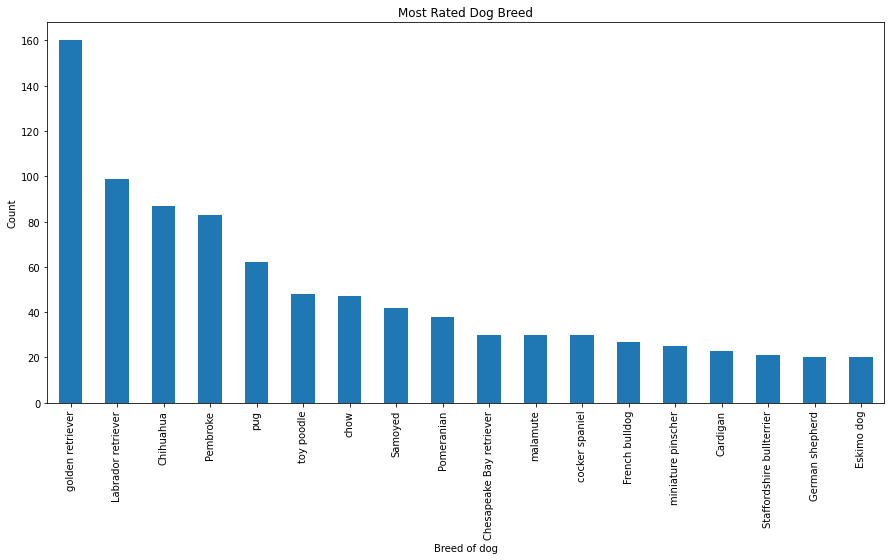

In [76]:
# Histogram to visualize dog breeeds (I included only breeds with at least 20 votes)
breed = breed.groupby('dog_breed').filter(lambda x: len(x) >= 20)

breed['dog_breed'].value_counts().plot(kind = 'bar', figsize = (15,7))
plt.title('Most Rated Dog Breed')
plt.xlabel('Breed of dog')
plt.ylabel('Count');

- **The most rated dog breed is golden retriever (a verification of the ML algorithm behind the image verification file)**
- Below is a random image of an golden retriever from the dataset

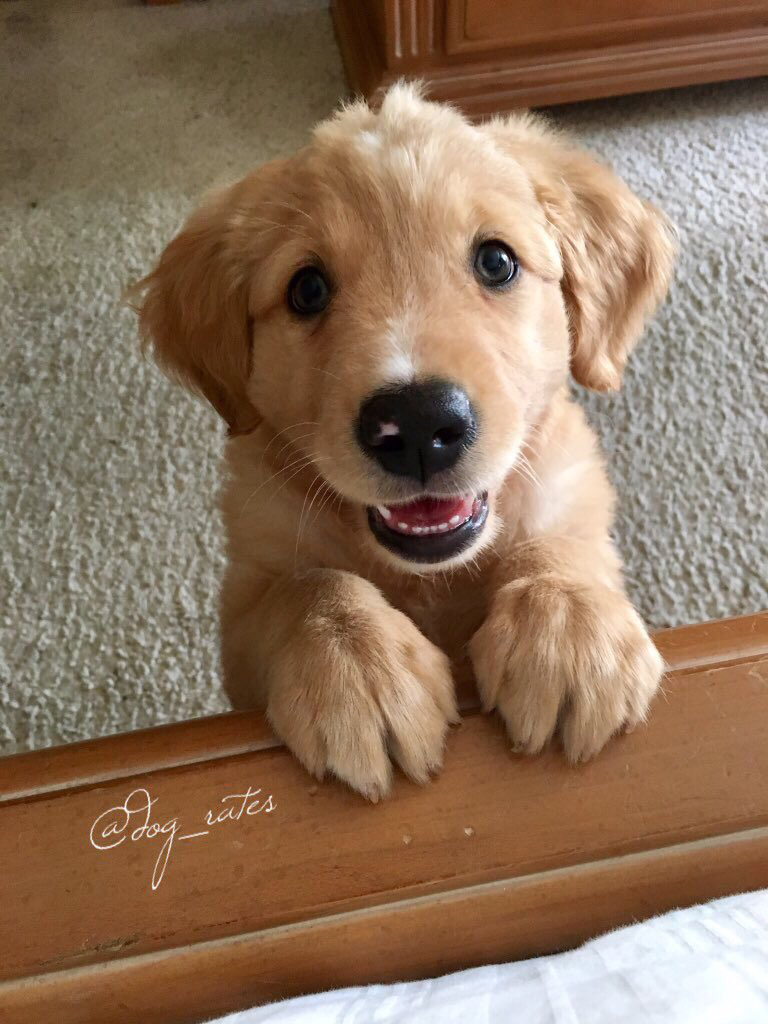

In [88]:
sample_image = breed[breed['dog_breed'] == 'golden retriever']
img = sample_image.sample(1).jpg_url.to_string(index=False)

from PIL import Image
import requests
from io import BytesIO

response = requests.get(img)
img = Image.open(BytesIO(response.content))
img

- Analyze and Visualize: Visualizing the most popular dog names

In [78]:
# making a name dataframe without None and Null values for nicer plot 
dog_name = df[df["name"] != "None"]
dog_name.dropna()
dog_name = dog_name.name.value_counts()

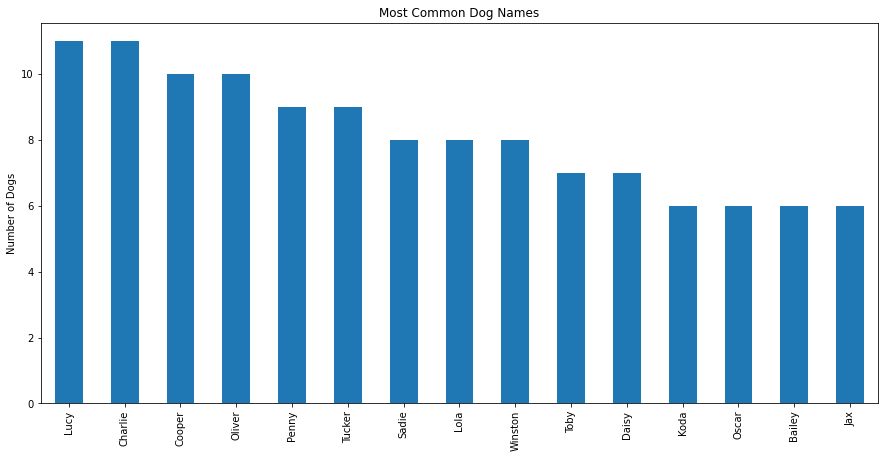

In [79]:
# Histogram to visualize most rated dog names (I included only the 15 most common names)
dog_name[0:15].plot(kind = 'bar', figsize=(15,7), title='Most Common Dog Names').set_ylabel("Number of Dogs");

- **The most common dog names are Charlie & Lucy with Oliver & Cooper as runner-ups**
- Below is a random image of a Lucy or a Charlie

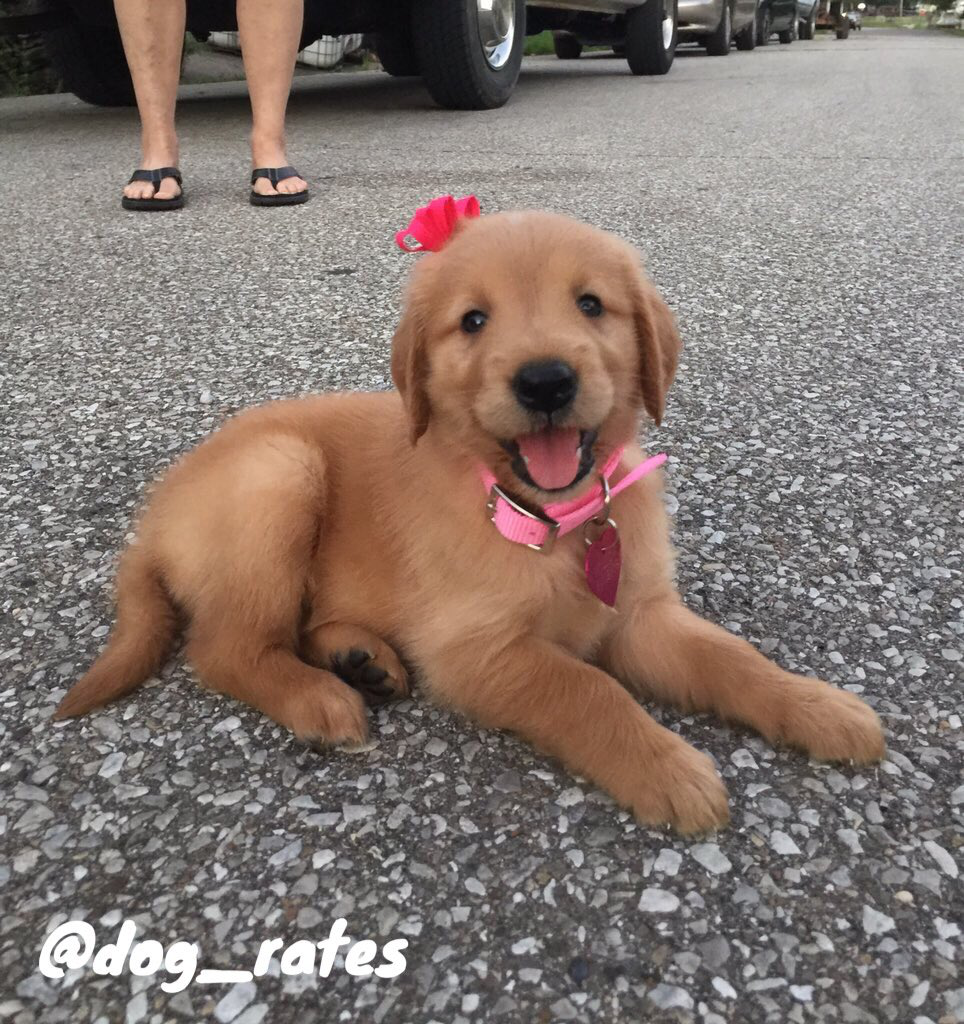

In [80]:
sample_lucy = df[df['name'] == 'Lucy']
sample_charlie = df[df['name'] == 'Charlie']
img_lucy = sample_lucy.sample(1).jpg_url.to_string(index=False)
img_charlie = sample_charlie.sample(1).jpg_url.to_string(index=False)

from PIL import Image
import requests
from io import BytesIO

response_lucy = requests.get(img_charlie)
response_charlie = requests.get(img_charlie)
img_lucy = Image.open(BytesIO(response_lucy.content))
img_charlie = Image.open(BytesIO(response_charlie.content))
img_lucy
# img_charlie

- Analyze and Visualize: Visualizing the total number of tweets over time to see whether that number increases, or decreases, over time

In [81]:
df.timestamp = pd.to_datetime(df['timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
monthly_tweets = df.groupby(pd.Grouper(key = 'timestamp', freq = "M")).count().reset_index()
monthly_tweets = monthly_tweets[['timestamp', 'tweet_id']]
monthly_tweets.head()

,timestamp,tweet_id
0,2015-11-30,300
1,2015-12-31,388
2,2016-01-31,194
3,2016-02-29,125
4,2016-03-31,136


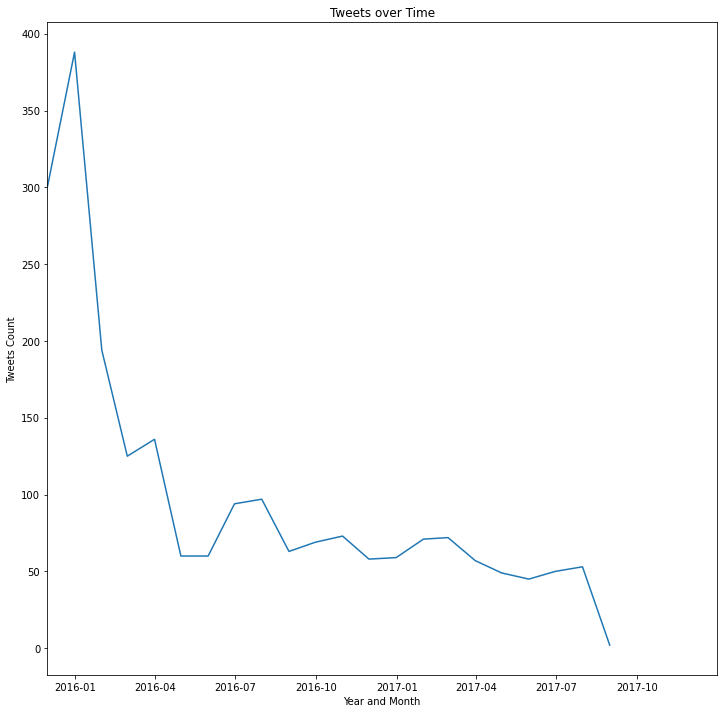

In [82]:
import datetime
plt.figure(figsize=(12, 12));
plt.xlim([datetime.date(2015, 11, 30), datetime.date(2017, 12, 31)]);

plt.xlabel('Year and Month')
plt.ylabel('Tweets Count')

plt.plot(monthly_tweets.timestamp, monthly_tweets.tweet_id);
plt.title('Tweets over Time');

- We can see that tweets are drastically decreasing over time

- Analyze and Visualize: Visualizing the retweet counts, and favorite counts comparison over time

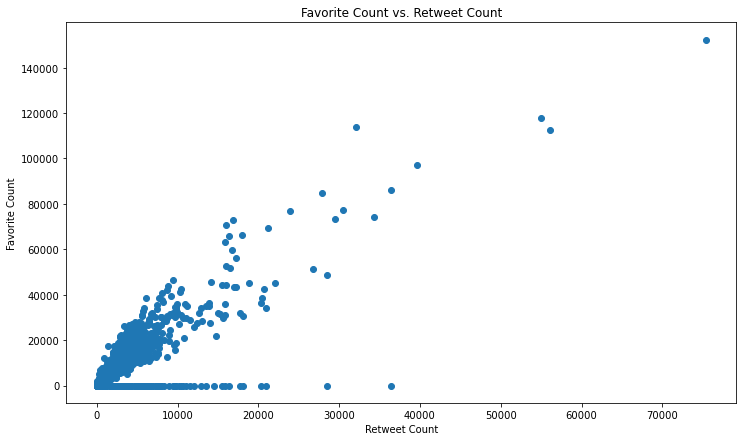

In [83]:
plt.figure(figsize=(12, 7))
plt.scatter(x="retweet_count", 
           y="favorite_count", 
           data=df);

plt.title('Favorite Count vs. Retweet Count');
plt.xlabel('Retweet Count');
plt.ylabel('Favorite Count');

- As we can see there is a positive correlation between Retweet Counts and Favorite Counts